In [23]:
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt

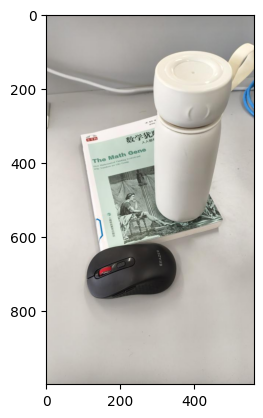

In [32]:
Ds = ["0","1"]

img = cv2.imread("./dataset_U/1.jpg") # BGR
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # RGB
img_np = np.array(RGB_img)
plt.imshow(img_np)

In [27]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt

def transpose_to_binary(path, classes):
    # 确保路径和文件存在
    if not os.path.exists(path + ".jpg") or not os.path.exists(path + ".json"):
        print(f"Error: Image or JSON file does not exist at {path}")
        return

    with open(path + ".json") as f:
        label = json.load(f)
    
    img = cv2.imread(path + ".jpg")
    if img is None:
        print(f"Error: Failed to load image at {path}.jpg")
        return

    h, w = img.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)  # 创建一个2D的掩码

    shapes = label["shapes"]
    for index, shape in enumerate(shapes):
        category = shape["label"]
        if category in classes:
            points = shape["points"]
            points_array = np.array(points, dtype=np.int32)
            # 填充多边形，确保类别索引在0-255范围内
            mask = cv2.fillPoly(mask, [points_array], classes.index(category) + 1)

    # 将掩码转换为二值化图像
    binary_mask = (mask > 0).astype(np.uint8) * 255  # 二值化处理

    # 显示并保存二值化图像
    plt.figure(figsize=(w/100, h/100))  # 设置图形大小与原图比例相同
    plt.imshow(255 - binary_mask, cmap='binary')
    plt.axis('off')
    plt.savefig(path + "_binary.jpg", bbox_inches='tight', pad_inches=0, dpi=300)  # 保存为高分辨率图像
    plt.close()  # 关闭图形窗口

    # 如果还需要保存原始掩码图像
    cv2.imwrite(f"{path}_mask.png", mask)

In [28]:
import os
file_list = os.listdir("dataset_U/")
file_list = [file for file in file_list if file[-3:] == "jpg"]


In [30]:
for file in file_list:
    transpose_to_binary("./dataset_U/"+file[:-4],["0","1","2","3"])

In [31]:
# 用PIL 等比例缩放，要求最长边不超过1000pix
# 保存为jpg格式,覆盖原图


import os
import PIL
def resize_img(path):
    img = PIL.Image.open(path)
    w, h = img.size
    if w > h:
        new_w = 1000
        new_h = int(h * 1000 / w)
    else:
        new_h = 1000
        new_w = int(w * 1000 / h)
    img = img.resize((new_w, new_h))
    img.save(path, "JPEG")

file_list = os.listdir("dataset_U/")
file_list = [file for file in file_list if file[-3:] == "jpg"]
for file in file_list:
    resize_img("./dataset_U/"+file)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import segmentation_models_pytorch as smp
from tqdm import tqdm

# One-Hot 编码函数
def one_hot_encode(mask, num_classes):
    """
    将掩码转换为 one-hot 编码。

    Args:
        mask: 形状为 (batch_size, height, width) 或 (height, width) 的掩码张量。
        num_classes: 类别的数量。

    Returns:
        形状为 (batch_size, num_classes, height, width) 的 one-hot 编码张量。
    """
    if mask.ndim == 3:  # (batch_size, height, width)
      batch_size, height, width = mask.size()
      one_hot = torch.zeros((batch_size, num_classes, height, width), dtype=torch.float, device=mask.device)
      # 使用 scatter_ 将 one_hot 中对应类别的位置设置为 1
      one_hot.scatter_(1, mask.unsqueeze(1).long(), 1.0)
    elif mask.ndim==2:
      height, width = mask.size()
      one_hot = torch.zeros((num_classes, height, width), dtype=torch.float, device=mask.device)
      # 使用 scatter_ 将 one_hot 中对应类别的位置设置为 1
      one_hot.scatter_(0, mask.unsqueeze(0).long(), 1.0)
    return one_hot

# Dice Loss
def dice_loss(pred, target, smooth=1e-6, num_classes=4):
    pred = torch.softmax(pred, dim=1) # 对每个类别应用 softmax
    target = one_hot_encode(target, num_classes)  # 现在 target 的形状是 (batch_size, num_classes, height, width)

    intersection = (pred * target).sum(dim=(0, 2, 3))  # 在 batch 和空间维度上求和
    union = pred.sum(dim=(0, 2, 3)) + target.sum(dim=(0, 2, 3))  # 同上

    return 1 - (2. * intersection + smooth) / (union + smooth)

# 数据集定义
class SimpleDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        # 加载图像文件路径
        self.image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))])
        self.mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))])
        # 确保图像和掩码的数量匹配
        assert len(self.image_paths) == len(self.mask_paths), "The number of images and masks must be equal!"

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            # 读取图像和掩码
            image = Image.open(self.image_paths[idx]).convert('RGB')
            mask = Image.open(self.mask_paths[idx]).convert('L')  # 使用灰度模式读取掩码
            if self.transform:
                image = self.transform(image)
            else:
                image = transforms.ToTensor()(image)
            # 将掩码转换为 Tensor，并映射到类别索引
            mask = transforms.ToTensor()(mask).long()  # 转换为 long 类型，保证类别索引的正确性
            mask = mask.squeeze()  # 移除多余的维度，确保是 (H, W)
            return image, mask
        except Exception as e:
            print(f"加载数据出错，索引：{idx}")
            print(f"图像路径：{self.image_paths[idx]}")
            print(f"掩码路径：{self.mask_paths[idx]}")
            print(f"错误信息：{e}")
            raise  # 抛出异常

# 定义变换（现在不需要 Resize 了）
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 假设图像和掩码分别在'images/'和'masks/'目录下
image_dir = 'dataset_U/origin'
mask_dir = 'dataset_U/mask'

# 初始化数据集
dataset = SimpleDataset(image_dir=image_dir, mask_dir=mask_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

# 使用UNet模型，但不加载预训练权重
model = smp.Unet(
    encoder_name="resnet18",  # 选择一个轻量级的编码器
    encoder_weights=None,  # 不加载预训练权重
    in_channels=3,  # 输入通道数
    classes=4,  # 输出类别数
)

# 优化器
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 设备选择
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# model.load_state_dict(torch.load('unet_model_from_scratch.pth'))
model.train()
# 训练循环
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, masks in (dataloader):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = dice_loss(outputs, masks).mean()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    if epoch % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {epoch_loss/len(dataloader):.4f}')

# 保存模型
torch.save(model.state_dict(), 'unet_model_from_scratch.pth')
print("训练完成，模型已保存。")

Resizing images:   0%|          | 0/4 [00:00<?, ?it/s]

Resizing masks: 100%|██████████| 4/4 [00:00<00:00, 14.60it/s]


Epoch [1/1000], Average Loss: 0.8585
Epoch [21/1000], Average Loss: 0.7892
Epoch [41/1000], Average Loss: 0.7709
Epoch [61/1000], Average Loss: 0.7622
Epoch [81/1000], Average Loss: 0.7580
Epoch [101/1000], Average Loss: 0.7556
Epoch [121/1000], Average Loss: 0.7541
Epoch [141/1000], Average Loss: 0.7530
Epoch [161/1000], Average Loss: 0.7523
Epoch [181/1000], Average Loss: 0.7518
Epoch [201/1000], Average Loss: 0.7515
Epoch [221/1000], Average Loss: 0.7512
Epoch [241/1000], Average Loss: 0.7510
Epoch [261/1000], Average Loss: 0.7508
Epoch [281/1000], Average Loss: 0.7507
Epoch [301/1000], Average Loss: 0.7506
Epoch [321/1000], Average Loss: 0.7506
Epoch [341/1000], Average Loss: 0.7505
Epoch [361/1000], Average Loss: 0.7504
Epoch [381/1000], Average Loss: 0.7504
Epoch [401/1000], Average Loss: 0.7503
Epoch [421/1000], Average Loss: 0.7503
Epoch [441/1000], Average Loss: 0.7503
Epoch [461/1000], Average Loss: 0.7503
Epoch [481/1000], Average Loss: 0.7502
Epoch [501/1000], Average Loss:

In [ ]:
from torchvision.utils import save_image
import torch
from PIL import Image
from torchvision import transforms

# 确保模型加载正确
model = smp.Unet(
    encoder_name="resnet18",  # 使用轻量级编码器
    encoder_weights=None,  # 这里假设不使用预训练权重
    in_channels=3,  # 输入通道数
    classes=4,  # 输出类别数
)
model.load_state_dict(torch.load('unet_model_from_scratch.pth'))
model.eval()  # 切换为评估模式

# 定义变换
transform = transforms.Compose([
    transforms.Resize((384, 256)),  # 确保与训练时尺寸一致
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def inference_and_save(image_path, model, transform, output_path):
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)  # 增加 batch 维度

    with torch.no_grad():
        output = model(image_tensor)
        print(f"Output before softmax: min={output.min()}, max={output.max()}, mean={output.mean()}")
        output_softmax = torch.softmax(output, dim=1)
        print(f"Output after softmax: min={output_softmax.min()}, max={output_softmax.max()}, mean={output_softmax.mean()}")

        # 统计每个类别的像素数量
        for i in range(4):  # 假设有4个类别
            print(f"Class {i}: {(output_softmax.argmax(dim=1) == i).sum()} pixels")

        # 保存第一个类别的概率图
        save_image(output_softmax[0, 1:2, :, :], "probability_map_class_1.png")

        output = torch.argmax(output_softmax, dim=1)

    color_map = torch.tensor([
        [128, 128, 128],  # 背景 - 灰色
        [255, 0, 0],      # 第一个类别 - 红色
        [0, 255, 0],      # 第二个类别 - 绿色
        [0, 0, 255],      # 第三个类别 - 蓝色
    ]).float() / 255.0

    output_rgb = color_map[output.long()].permute(0, 3, 1, 2)
    save_image(output_rgb, output_path)

# 推理并保存
test_image_path = 'input.jpg'
output_path = 'output.jpg'
inference_and_save(test_image_path, model, transform, output_path)


Output before softmax: min=-13.907831192016602, max=7.461115837097168, mean=-0.2967239320278168
Output after softmax: min=1.2910785773811995e-09, max=0.999961256980896, mean=0.2499999850988388
Class 0: 75245 pixels
Class 1: 559 pixels
Class 2: 13791 pixels
Class 3: 8709 pixels
